# Assistants API - Function Calling

An assistant is a purpose-built AI that has specific instructions, leverages extra knowledge, and can call models and tools to perform tasks.

https://platform.openai.com/docs/assistants/tools/function-calling

https://cookbook.openai.com/examples/assistants_api_overview_python

https://dev.to/esponges/build-the-new-openai-assistant-with-function-calling-52f5 

https://community.openai.com/t/function-calling-with-assistants-api/488259/2 

https://community.openai.com/t/function-calling-with-assistants-api/488259 

https://dev.to/airtai/function-calling-and-code-interpretation-with-openais-assistant-api-a-quick-and-simple-tutorial-5ce5

https://cobusgreyling.medium.com/what-are-openai-assistant-function-tools-exactly-06ef8e39b7bd

Watch:

https://www.youtube.com/watch?v=BV-_5_r46kE&t=0s

https://www.youtube.com/watch?v=SaJxbuKehpc 


In [3]:
from openai import OpenAI
import json
from dotenv import load_dotenv, find_dotenv

_ : bool = load_dotenv("E:/Python/.env") # read local .env file

In [4]:
client : OpenAI = OpenAI()

### Function calling

Similar to the Chat Completions API, the Assistants API supports function calling. Function calling allows you to describe functions to the Assistants and have it intelligently return the functions that need to be called along with their arguments. The Assistants API will pause execution during a Run when it invokes functions, and you can supply the results of the function call back to continue the Run execution.



### Step 0: Define functions
First, define your functions:

In [5]:
# Example dummy function hard coded to return the same weather
# In production, this could be your backend API or an external API
def getCurrentWeather(location:str, unit:str="fahrenheit")->str | dict | None:
    """Get the current weather in a given location"""
    if "tokyo" in location.lower():
        return json.dumps({"location": "Tokyo", "temperature": "10", "unit": "celsius"})
    elif "los angeles" in location.lower():
        return json.dumps({"location": "San Francisco", "temperature": "72", "unit": "fahrenheit"})
    elif "paris" in location.lower():
        return json.dumps({"location": "Paris", "temperature": "22", "unit": "celsius"})
    else:
        return json.dumps({"location": location, "temperature": "unknown"})
    

def getNickname(location:str)->str:
    """Get the nickname of a city"""
    if "tokyo" in location.lower():
        return "tk"
    elif "los angeles" in location.lower():
        return "la"
    elif "paris" in location.lower():
        return "py"
    else:
        return location



### Step 1: Create an Assistant and register/report your functions

In [6]:
import json

def show_json(message, obj):
    display(message, json.loads(obj.model_dump_json()))

In [7]:
from openai.types.beta import Assistant

assistant: Assistant = client.beta.assistants.create(
  instructions="You are a weather bot. Use the provided functions to answer questions.",
  model="gpt-3.5-turbo-1106",
  tools=[{
      "type": "function",
    "function": {
      "name": "getCurrentWeather",
      "description": "Get the weather in location",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {"type": "string", "description": "The city and state e.g. San Francisco, CA"},
          "unit": {"type": "string", "enum": ["c", "f"]}
        },
        "required": ["location"]
      }
    }
  }, {
    "type": "function",
    "function": {
      "name": "getNickname",
      "description": "Get the nickname of a city",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {"type": "string", "description": "The city and state e.g. San Francisco, CA"},
        },
        "required": ["location"]
      }
    } 
  }]
)


### Step 2: Create a Thread

In [8]:
from openai.types.beta.thread import Thread

thread: Thread  = client.beta.threads.create()

print(thread)


Thread(id='thread_7P3Fgbw081EChwk9RLomVBu1', created_at=1702709352, metadata={}, object='thread')


### Step 3: Add a Message to a Thread

In [16]:
from openai.types.beta.threads.thread_message import ThreadMessage

# First Request
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="How is the weather in Tokyo?"
)


In [17]:
dict(message)

{'id': 'msg_9hGuUQwLsW5csbzBIewWv5UY',
 'assistant_id': None,
 'content': [MessageContentText(text=Text(annotations=[], value='How is the weather in Tokyo?'), type='text')],
 'created_at': 1702709538,
 'file_ids': [],
 'metadata': {},
 'object': 'thread.message',
 'role': 'user',
 'run_id': None,
 'thread_id': 'thread_7P3Fgbw081EChwk9RLomVBu1'}

### Step 4: Run the Assistant

In [18]:
from openai.types.beta.threads.run import Run

run: Run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)


In [19]:
dict(run)

{'id': 'run_vc43baK5mKfXYJv6C5qjg9Oe',
 'assistant_id': 'asst_SZa7ntHZnTiZHaESAcww5ITH',
 'cancelled_at': None,
 'completed_at': None,
 'created_at': 1702709545,
 'expires_at': 1702710145,
 'failed_at': None,
 'file_ids': [],
 'instructions': 'You are a weather bot. Use the provided functions to answer questions.',
 'last_error': None,
 'metadata': {},
 'model': 'gpt-3.5-turbo-1106',
 'object': 'thread.run',
 'required_action': None,
 'started_at': None,
 'status': 'queued',
 'thread_id': 'thread_7P3Fgbw081EChwk9RLomVBu1',
 'tools': [ToolAssistantToolsFunction(function=FunctionDefinition(name='getCurrentWeather', parameters={'type': 'object', 'properties': {'location': {'type': 'string', 'description': 'The city and state e.g. San Francisco, CA'}, 'unit': {'type': 'string', 'enum': ['c', 'f']}}, 'required': ['location']}, description='Get the weather in location'), type='function'),
  ToolAssistantToolsFunction(function=FunctionDefinition(name='getNickname', parameters={'type': 'object

## Run Life Cycle

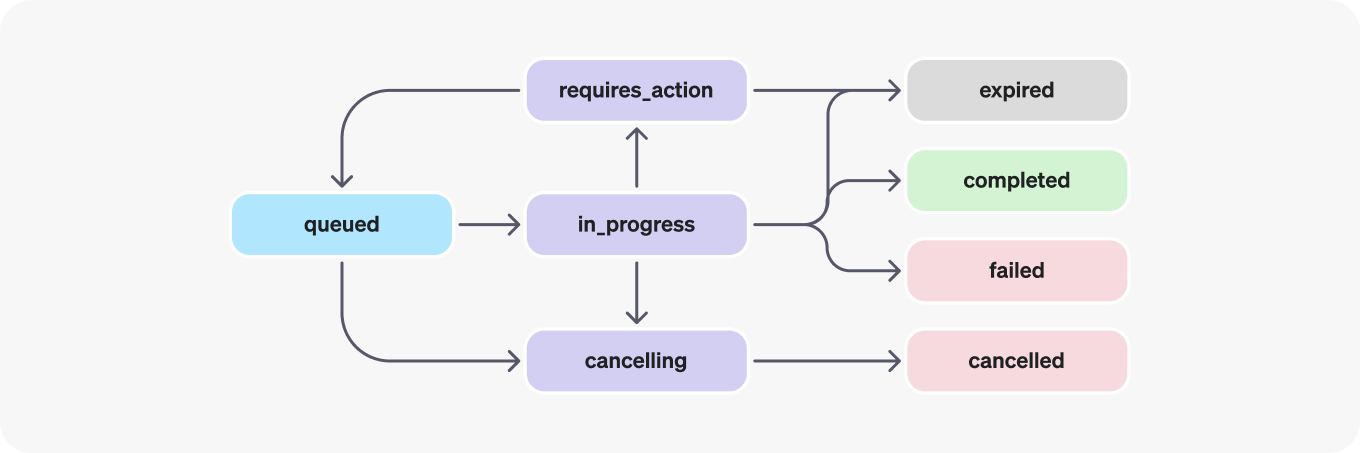

### STATUS	DEFINITION

https://platform.openai.com/docs/assistants/how-it-works/runs-and-run-steps

queued:	

When Runs are first created or when you complete the required_action, they are moved to a queued status. They should almost immediately move to in_progress.

in_progress:	

While in_progress, the Assistant uses the model and tools to perform steps. You can view progress being made by the Run by examining the Run Steps.

completed:	

The Run successfully completed! You can now view all Messages the Assistant added to the Thread, and all the steps the Run took. You can also continue the conversation by adding more user Messages to the Thread and creating another Run.

requires_action:	

When using the Function calling tool, the Run will move to a required_action state once the model determines the names and arguments of the functions to be called. You must then run those functions and submit the outputs before the run proceeds. If the outputs are not provided before the expires_at timestamp passes (roughly 10 mins past creation), the run will move to an expired status.

expired:

This happens when the function calling outputs were not submitted before expires_at and the run expires. Additionally, if the runs take too long to execute and go beyond the time stated in expires_at, our systems will expire the run.

cancelling:	

You can attempt to cancel an in_progress run using the Cancel Run endpoint. Once the attempt to cancel succeeds, status of the Run moves to cancelled. Cancellation is attempted but not guaranteed.
cancelled	Run was successfully cancelled.

failed:	

You can view the reason for the failure by looking at the last_error object in the Run. The timestamp for the failure will be recorded under failed_at.

### Polling for updates

In order to keep the status of your run up to date, you will have to periodically retrieve the Run object. You can check the status of the run each time you retrieve the object to determine what your application should do next. We plan to add support for streaming to make this simpler in the near future.

### Thread locks

When a Run is in_progress and not in a terminal state, the Thread is locked. This means that:

New Messages cannot be added to the Thread.

New Runs cannot be created on the Thread.

## Run steps

![Alt text](diagram-2.png "run steps")

Most of the interesting detail in the Run Step object lives in the step_details field. There can be two types of step details:

1. message_creation: This Run Step is created when the Assistant creates a Message on the Thread.
2. tool_calls: This Run Step is created when the Assistant calls a tool. Details around this are covered in the relevant sections of the Tools guide.


In [20]:
available_functions = {
    "getCurrentWeather": getCurrentWeather,
    "getNickname": getNickname
} 

In [21]:
thread.id

'thread_7P3Fgbw081EChwk9RLomVBu1'

### Step 5: Polling for Updates and Calling Functions

In [22]:
import time

  # Loop until the run completes or requires action
while True:
    runStatus = client.beta.threads.runs.retrieve(thread_id=thread.id,
                                                  run_id=run.id)
    # Add run steps retrieval here for debuging
    run_steps = client.beta.threads.runs.steps.list(thread_id=thread.id, run_id=run.id)
    # show_json("Run Steps:", run_steps)
    print(runStatus.status ,'.....')

    # This means run is making a function call   
    if runStatus.status == "requires_action":
        print(runStatus.status ,'.....')
        print("Status: ", "requires_action")
        show_json("submit_tool_outputs", runStatus.required_action)
        if runStatus.required_action.submit_tool_outputs and runStatus.required_action.submit_tool_outputs.tool_calls:
            print("toolCalls present:")
            toolCalls = runStatus.required_action.submit_tool_outputs.tool_calls

            tool_outputs = []
            for toolcall in toolCalls:
                function_name = toolcall.function.name
                function_args = json.loads(toolcall.function.arguments)
                
                if function_name in available_functions:
                    
                    
                    function_to_call = available_functions[function_name]
                    print(function_to_call,function_to_call.__name__=="getCurrentWeather","================================================================")
                  
                    if function_to_call.__name__ == "getCurrentWeather":
                        
                        response = function_to_call(
                        location=function_args.get("location"),
                        unit=function_args.get("unit")
                        )
                        
                        
                        tool_outputs.append({
                                  "tool_call_id": toolcall.id,
                                  "output": response
                              })
                    
                    elif function_to_call.__name__ == "getNickname":
                        response = function_to_call(
                          location=function_args.get("location")
                          )
                        tool_outputs.append({
                          "tool_call_id": toolcall.id,
                          "output": response,
                              })
            print(tool_outputs,">>>>>") 
            # Submit tool outputs and update the run
            client.beta.threads.runs.submit_tool_outputs(
                thread_id=thread.id,
                run_id=run.id,
                tool_outputs=tool_outputs)
      
    elif runStatus.status == "completed":
        # List the messages to get the response
        print("completed...........logic")
        messages: list[ThreadMessage] = client.beta.threads.messages.list(thread_id=thread.id)
        for message in messages.data:
            role_label = "User" if message.role == "user" else "Assistant"
            message_content = message.content[0].text.value
            print(f"{role_label}: {message_content}\n")
        break  # Exit the loop after processing the completed run

    elif run.status == "failed":
      print("Run failed.")
      break

    elif run.status in ["in_progress", "queued"]:
      print(f"Run is {run.status}. Waiting...")
      time.sleep(5)  # Wait for 5 seconds before checking again

    else:
      print(f"Unexpected status: {run.status}")
      break




requires_action .....
requires_action .....
Status:  requires_action


'submit_tool_outputs'

{'submit_tool_outputs': {'tool_calls': [{'id': 'call_ZBpUqIeA49ZLKludBH8oIg7d',
    'function': {'arguments': '{"location": "Tokyo", "unit": "c"}',
     'name': 'getCurrentWeather'},
    'type': 'function'},
   {'id': 'call_fRHxuw3LqtLE1yCJ57r3s2Fd',
    'function': {'arguments': '{"location": "Tokyo"}', 'name': 'getNickname'},
    'type': 'function'}]},
 'type': 'submit_tool_outputs'}

toolCalls present:
<function getCurrentWeather at 0x000001DD88C844A0> True ================================================================
<function getNickname at 0x000001DD88C84540> False ================================================================
[{'tool_call_id': 'call_ZBpUqIeA49ZLKludBH8oIg7d', 'output': '{"location": "Tokyo", "temperature": "10", "unit": "celsius"}'}, {'tool_call_id': 'call_fRHxuw3LqtLE1yCJ57r3s2Fd', 'output': 'tk'}] >>>>>
in_progress .....
Run is queued. Waiting...
completed .....
completed...........logic
Assistant: The current weather in Tokyo is 10°C and it's known as "TK".

User: How is the weather in Tokyo?

Assistant: I'm sorry, I couldn't retrieve the current weather for Karachi at the moment.

User: How is the weather in Karachi?

